### From chapter 6

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 50)
from pathlib import Path

import matplotlib.pyplot as plt

BASE_PATH = Path("../DATASETS/6")

In [2]:
import html 
import re
# tags like 
RE_TAG = re.compile(r'<[^<>]*>')
# text or code in brackets like [0]
RE_BRACKET = re.compile('\[[^\[\]]*\]')
# text or code in brackets like (0)
RE_BRACKET_1 = re.compile('\([^)]*\)')
# specials that are not part of words; matches # but not #cool
RE_SPECIAL = re.compile(r'(?:^|\s)[&#<>{}\[\]+]+(?:\s|$)')
# standalone sequences of hyphens like --- or ==
RE_HYPHEN_SEQ = re.compile(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)')
# sequences of white spaces
RE_MULTI_SPACE = re.compile('\s+')

def clean(text):
    text = html.unescape(text)
    text = RE_TAG.sub(' ', text)
    text = RE_BRACKET.sub(' ', text)
    text = RE_BRACKET_1.sub(' ', text)
    text = RE_SPECIAL.sub(' ', text)
    text = RE_HYPHEN_SEQ.sub(' ', text)
    text = RE_MULTI_SPACE.sub(' ', text)
    return text.strip()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Loading the dataframe

df = pd.read_csv(BASE_PATH/"eclipse_jdt.csv.gz")
df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample, random_state=42, frac=.2)
df = df[['Title','Description','Component']]
df = df.dropna()
df['text'] = df['Title'] + " " + df['Description']
df = df.drop(columns=['Title','Description'])

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split

X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['Component'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=df['Component'])
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)


svc = SVC(kernel="linear", C=1, probability=True, random_state=42)
svc.fit(X_train_tf, Y_train)

Size of Training Data  7240
Size of Test Data  1811


SVC(C=1, kernel='linear', probability=True, random_state=42)

In [5]:
X_test_tf = tfidf.transform(X_test)
Y_pred = svc.predict(X_test_tf)
result = pd.DataFrame({ 'text': X_test.values, 'actual': Y_test.values, 'predicted': Y_pred })

### Determining Classication Condence Using Prediction Probability


In [6]:
result[result["actual"] != result["predicted"]].head()

,text,actual,predicted
2,NPE in Delta processor while executing JDT/UI ...,Core,UI
15,Inserting a block of text in editor badly alig...,UI,Text
16,Differences when debugging identical objects W...,Debug,Core
20,Foreach template doesnt work for class members...,Core,UI
21,exchange left and right operands for compariso...,UI,Core


In [8]:
text = result.iloc[21]["text"]
print(text)

exchange left and right operands for comparison operators changes semantics Fix for Bug 149803 was not good.; ; The right fix should do the following; if --> if --> if ; if ; if


In [12]:
svc.predict_proba(X_test_tf[21])

array([[0.002669  , 0.46736578, 0.07725225, 0.00319434, 0.06874877,
        0.38076986]])

In [15]:
class_names = ["APT", "Core", "Debug", "Doc", "Text", "UI"]
prob = svc.predict_proba(X_test_tf)

In [18]:
er = result.copy().reset_index()

In [19]:
for i, c in enumerate(class_names):
    er[c] = prob[:, i]

In [20]:
er[["actual", "predicted"] + class_names].sample(5, random_state=99)

,actual,predicted,APT,Core,Debug,Doc,Text,UI
266,UI,UI,0.000598,0.000929,0.000476,0.001377,0.224473,0.772148
835,Text,Text,0.002083,0.032109,0.001481,0.002085,0.696666,0.265577
998,Text,Text,0.000356,0.026525,0.003425,0.000673,0.942136,0.026884
754,Core,Text,0.003862,0.334308,0.011312,0.015478,0.492112,0.142927
686,UI,UI,0.019319,0.099088,0.143744,0.082969,0.053174,0.601705


In [24]:
er['max_probability'] = er[class_names].max(axis=1)

In [25]:
correct = (er[er['actual'] == er['predicted']])
wrong = (er[er['actual'] != er['predicted']])

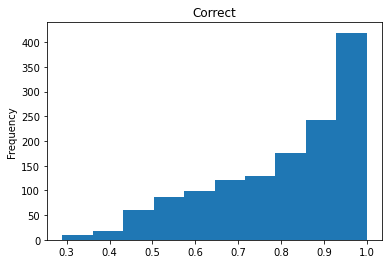

In [28]:
correct['max_probability'].plot.hist(title = 'Correct');

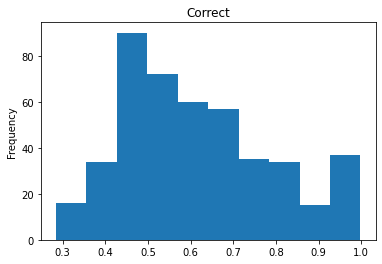

In [29]:
wrong['max_probability'].plot.hist(title = 'Correct');

We can see that in the case of correct predictions, the model often decided with high
probabilities, whereas the probabilities were considerably lower when the decision
was wrong. As we will see later, the small peak in the wrong category with high prob‐
ability is due to short texts or missing words.
Finally, we will take a look at whether we can improve the results if we only consider
decisions that have been made with a probability of more than 80%:

In [30]:
high = er[er['max_probability'] > .8]

In [32]:
print(classification_report(high['actual'], high['predicted']))

              precision    recall  f1-score   support

         APT       0.90      0.75      0.82        12
        Core       0.94      0.89      0.92       264
       Debug       0.94      0.99      0.96       202
         Doc       1.00      0.67      0.80         3
        Text       0.78      0.75      0.77        72
          UI       0.90      0.92      0.91       342

    accuracy                           0.91       895
   macro avg       0.91      0.83      0.86       895
weighted avg       0.91      0.91      0.91       895



In [33]:
#Compare this to the original result, shown here:
print(classification_report(er["actual"], er["predicted"]))

              precision    recall  f1-score   support

         APT       0.90      0.56      0.69        16
        Core       0.76      0.77      0.76       546
       Debug       0.90      0.78      0.84       302
         Doc       1.00      0.25      0.40        12
        Text       0.64      0.51      0.57       236
          UI       0.72      0.82      0.77       699

    accuracy                           0.75      1811
   macro avg       0.82      0.62      0.67      1811
weighted avg       0.75      0.75      0.75      1811



In this section, we have found a correlation between the predicting probability and
the quality of results.

### Measuring Feature Importance of Predictive Models

In [38]:
svc.coef_

<15x6403 sparse matrix of type '<class 'numpy.float64'>'
	with 64451 stored elements in Compressed Sparse Row format>

In [86]:
coef = svc.coef_[8].A[0]

In [87]:
vocabulary_positions = coef.argsort()
vocabulary = tfidf.get_feature_names_out()

In [88]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

In [89]:
data = [[vocabulary[c], coef[c]] for c in top_negative_coef+top_positive_coef]

In [90]:
core_ui = pd.DataFrame(
                data, columns=['features', 'coefficient']).sort_values("coefficient")

<AxesSubplot:title={'center':'core ui coefficient'}, ylabel='features'>

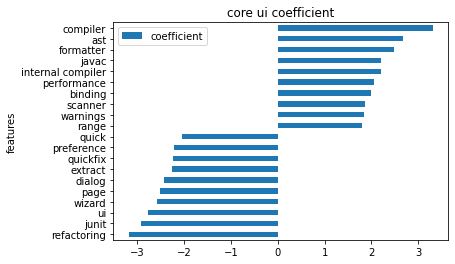

In [97]:
core_ui.set_index("features").plot.barh(title = 'core ui coefficient')

These results are quite easy to interpret. The SVM model has nicely learned that the
words compiler and ast are specific to the Core component, whereas wizard, ui, and
dialog are used to identify bugs in the UI component. It seems a quick fix is more
popular in the UI, which emphasizes the long-term stability of the core.

We have just found the features that are important for the whole SVM model to
choose between Core and UI. But this does not indicate which features are important
to identify a bug that can be categorized as Core given any bug report.

In [114]:
c = svc.coef_
coef = (c[5] + c[6] + c[7] + c[8] -  c[0]).A[0]
vocabulary_positions = coef.argsort()

In [115]:
top_words = 20

top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

In [123]:
data = [[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef]

In [124]:
core = pd.DataFrame(data, columns=['features', 'coefficient']).sort_values("coefficient")

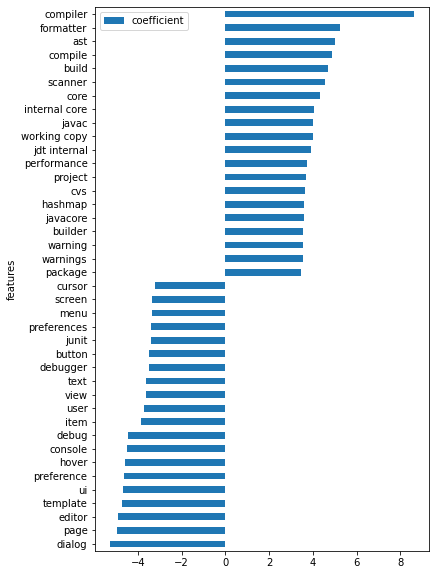

In [126]:
core.set_index("features").plot.barh(figsize=(6, 10));

In [120]:
c = svc.coef_
coef = (c[5] + c[6] + c[7] + c[8] - c[0]).A[0]
vocabulary_positions = coef.argsort()

In [121]:
top_words = 20
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()


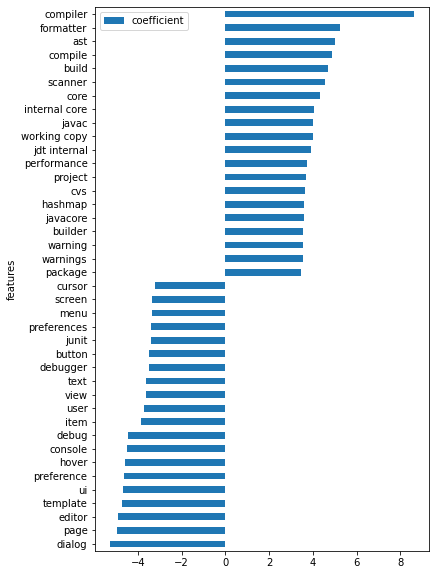

In [122]:
core = [[vocabulary[c], coef[c]] for c in top_negative_coef+top_positive_coef]

core = pd.DataFrame(core, columns=['features', 'coefficient']).sort_values("coefficient")
core.set_index("features").plot.barh(figsize=(6, 10));